In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

 In this portfolio, I have taken the data and build a predictive model to classify the books into one of the five target genres. I am  extracting suitable features from the texts and selecting a suitable model to classify them. 




## Data Preparation

The first task here is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/Portfolio Part 3-20200523/portfolio-3/data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

wid      fid                                      title           author  \
0   620  /m/0hhy                                Animal Farm    George Orwell   
1   843  /m/0k36                         A Clockwork Orange  Anthony Burgess   
2   986  /m/0ldx                                 The Plague     Albert Camus   
3  1756  /m/0sww  An Enquiry Concerning Human Understanding       David Hume   
4  2080  /m/0wkt                       A Fire Upon the Deep     Vernor Vinge   

         date                                             genres  \
0  1945-08-17  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1        1962  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2        1947  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                                  
4              {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape

(8954, 5)

In [4]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

title  author  date  summary
genre                                              
Children's literature   1092    1092  1092     1092
Fantasy                 2311    2311  2311     2311
Mystery                 1396    1396  1396     1396
Novel                   2258    2258  2258     2258
Science Fiction         1897    1897  1897     1897

## Modelling

Now we are going to build a suitable model and present results

In [5]:
print(len(genre_books))
print(genre_books.shape)
a=genre_books['genre'].value_counts()[:6]
b=a.keys().tolist()
print(b)
genre_books=genre_books[genre_books.genre.isin(b)]
genre_books=genre_books.reset_index(drop=True)


8954
(8954, 5)
['Fantasy', 'Novel', 'Science Fiction', 'Mystery', "Children's literature"]


In [6]:
len(set(genre_books))

5

In [7]:
genre_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8954 entries, 0 to 8953
Data columns (total 5 columns):
title      8954 non-null object
author     8954 non-null object
date       8954 non-null object
summary    8954 non-null object
genre      8954 non-null object
dtypes: object(5)
memory usage: 349.9+ KB


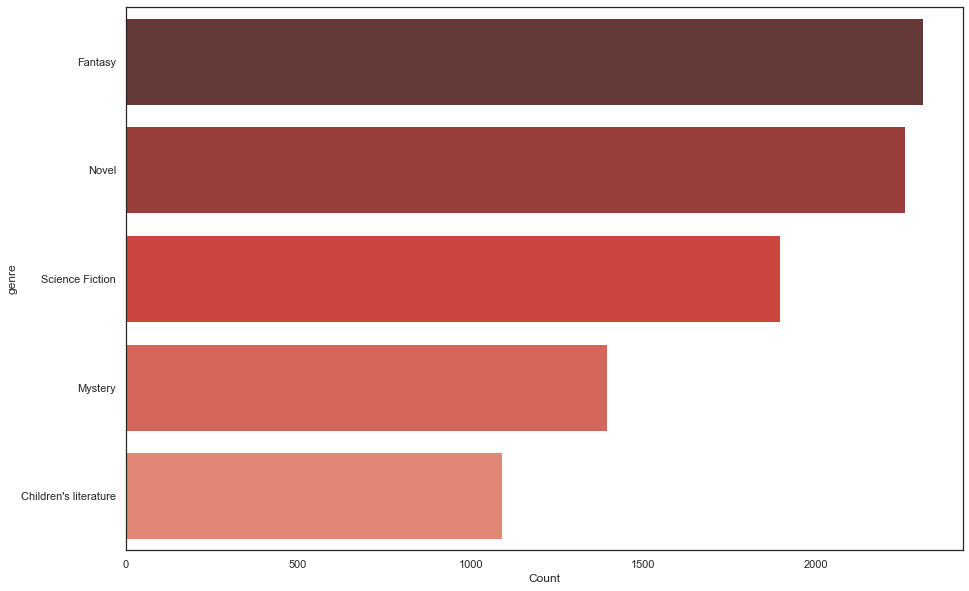

In [8]:

sns.set(style="white")
genre_to_count=pd.DataFrame({'genre':a.index,'Count':a.values})
plt.figure(figsize=(15,10))
sns.barplot(y="genre", x="Count", data=genre_to_count, palette="Reds_d")

In [9]:

def summaryToWords(raw_summary):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_summary)
    lower_case = letters_only.lower()
    words = lower_case.split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

def preprocess(dataframe):
    clean_train_reviews = []
    for i in range(0,len(dataframe)):
        clean_train_reviews.append(summaryToWords(dataframe.iloc[i]['summary']))
    dataframe['summary']=clean_train_reviews
    return dataframe

genre_books=preprocess(genre_books)
print(genre_books["summary"][:10])

0    old major old boar manor farm calls animals fa...
1    alex teenager living near future england leads...
2    text plague divided five parts town oran thous...
3    novel posits space around milky way divided co...
4    ged young boy gont one larger islands north ar...
5    living mars deckard acting consultant movie cr...
6    beginning several months events blade runner d...
7    story told eyes narrator james ballard named a...
8    nine years emperor paul muad dib walked desert...
9    situation desperate bene gesserit find targets...
Name: summary, dtype: object


In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), max_features=8000)
features = tfidf.fit_transform(genre_books.summary).toarray()
labels = genre_books.genre
features.shape

(8954, 8000)

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(genre_books['summary'], genre_books['genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


C:\Users\rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarn

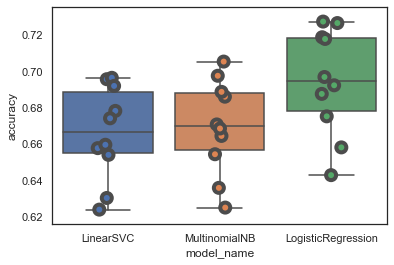

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
      LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_genre_books = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_genre_books = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_genre_books)
sns.stripplot(x='model_name', y='accuracy', data=cv_genre_books, 
              size=10, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

In [13]:
cv_genre_books.groupby('model_name').mean()

fold_idx  accuracy
model_name                            
LinearSVC                4.5  0.666187
LogisticRegression       4.5  0.694345
MultinomialNB            4.5  0.669657

The accuracy of the model is 0.694345 